In [1]:
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Acquisition
Dataset Description:
* 6 hand movements captured. 
* 3000 instances. 
* Two forearm surface EMG electrodes at Flexor Capri Ulnaris and Extensor Capri Radialis
* Sampling rate of 500 Hz.
* Filtered via a Butterworth Band Pass Filter with low and high cut-off at 15Hz and 500 Hz. Notch filter at 50 Hz.

<center><img src="Data/grasps_en.PNG" width="360" height="360"></center>

### Data Loading

5 subjects, 6 classes, 30 repetitions --> 900 data samples

### Note:
* To not include the effect of bias, the forward module has to be changed, in this case, even though the bias is being updated, it's effect is not seen in the model. Basically a dummy calculation

In [2]:
wavelets = ["bior3.5","bior1.5","bior3.9","coif3","coif5","db2","db9","haar","sym3","sym5","sym7"]
wave_type = 4
filename = "./Data/CSV/" + str(wavelets[wave_type]) + "_target.csv"
print(filename)
Y = pd.read_csv(filename, header=None)
Y = np.array(Y)
print(Y.shape)

filename = "./Data/CSV/" + str(wavelets[wave_type]) + "_ADDD.csv"
print(filename)
X = pd.read_csv(filename, header=None)
X = np.array(X)
print(X.shape)

N = X.shape[1]

X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size = 0.3, random_state = 0,shuffle = True)


X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

X_MAX = 1
X_MIN = -1
Xmin = np.min(X_train,axis=1)
Xmin = Xmin.reshape(Xmin.shape[0],1)
Xmax = np.max(X_train,axis=1)
Xmax = Xmax.reshape(Xmax.shape[0],1)

X_train = ((X_MAX - X_MIN) * (X_train - Xmin)/(Xmax-Xmin)) + Xmin
X_test = ((X_MAX - X_MIN) * (X_test - Xmin)/(Xmax-Xmin)) + Xmin

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

./Data/CSV/coif5_target.csv
(6, 900)
./Data/CSV/coif5_ADDD.csv
(8, 900)
(8, 630)
(8, 270)
(6, 630)
(6, 270)


### Activation Functions

$$linear(z) = z$$
$$relu(z) = max(0, z)$$
$$sigmoid(z) = 1 / (1 + e^{-z})$$
$$tanh(z) = 2/(1+e^{-2z})-1$$
$$softplus(z) = ln(1+e^{z})$$
$$Gaussian(z) = -z*e^{\frac{z^2}{2}}$$
$$MexicanHat(z) = (1-z^2)*e^{\frac{z^2}{2}}$$
$$MorletI(z) =0 cos(1.75z)*e^{\frac{z^2}{2}}$$
$$MorletII(z) = cos(5z)*e^{\frac{z^2}{2}}$$


In [3]:
def act_function(z,activation):
    """
    Inputs:
        z : z can either be a number or a numpy array
        activation: Python string denoting the activation function to be used in the current layer 
    Outputs:
        Activation function applied to z; if z is an array, the function must be applied to its each element
    """
    if activation == "linear":
        return z
    elif activation == "relu":
        return z*(z>0)
    elif activation == "sigmoid":
        return 1 / (1 + np.exp(-1*z))
    elif activation == "tanh":
        return (2 / (1 + np.exp(-2*z))) -1
    elif activation == "softplus":
        return np.log(1+ np.exp(z))
    elif activation == "softmax":
        e = z - np.max(z)
        return np.exp(e)/np.sum(np.exp(e))
    elif activation == "gaussian_wavelet":
        return -z*np.exp(-0.5*(z**2))
    elif activation == "mexican_hat_wavelet":
        return (1-(z**2))*np.exp(-0.5*(z**2))
    elif activation == "morlet_wavelet_1":
        return np.cos(1.75*z)*np.exp(-0.5*(z**2))
    elif activation == "morlet_wavelet_2":
        return np.cos(5*z)*np.exp(-0.5*(z**2))

### Initializing the Weights
The WNN will contain $H=1$ hidden layer and an output layer. For a layer $h$, we will have two parameters/variables:
  * Weight matrix $W^{[h]}$(of shape (size of current layer, size of previous layer)),
  * Bias vector $bias^{[h]}$(of shape (size of current layer, 1), 
  * Wavelet scaling factor $a^{[h]}$(of shape (size of current layer, 1),
  * Wavelet translation factor $b^{[h]}$(of shape (size of current layer, 1),

*   Used np.random.uniform(low, high, shape), with low=0.0 and high=0.01 to initialize the weights $W^{[h]}$ (<a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.uniform.html#numpy-random-uniform">np.random.uniform()</a>).a

*   Used np.random.uniform(low, high, shape), with low=0.0 and high=5 to initialize the scaling factor $a^{[h]}$ (<a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.uniform.html#numpy-random-uniform">np.random.uniform()</a>).

*   Used np.random.uniform(low, high, shape), with low=-10.0 and high=10 to initialize the translation factor $b^{[h]}$ (<a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.uniform.html#numpy-random-uniform">np.random.uniform()</a>).

*   Initialized biases $b^{[h]}$ with zeros (<a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html">np.zeros()</a>).

* **For Normal Neural Network a is initialized to 1 and b to 0**


* For a single-hidden layer NN with input of size 5, hidden layer size = 4 and output layer size =3, the input parameter ```layers_sizes``` will be **[5, 4, 3]**. The output of the ```construct_WNN()``` function will be  **```[[np.array(shape=(4, 5)), np.array(shape=(4, 1))], np.array(shape=(4, 1))], np.array(shape=(4, 1))], [np.array(shape=(3, 4)), np.array(shape=(3, 1))]]```**, with each numpy array initialised as mentioned above.`

In [4]:
def construct_WNN(layers_sizes,weight_types):
    """
    Inputs:
        layers_sizes: A list (of length H+2) containing the size (number of neurons) of each layer. Element at index 0 represents input layer size.  
        weight_types = A list denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        weights: A list (of length H), where each element is a list - [Wh, biash,ah,bh], representing the  weights matrix and bias vector of layer h (Both Wh and bh are numpy arrays).
    """
    low_W = 0
    high_W = 0.01
    low_a = 0
    high_a = 5
    low_b = -10
    high_b = 10
    H = len(layers_sizes)-2
    weights = []
    for h in range(H+1):
        w = np.random.uniform(low_W, high_W, (layers_sizes[h+1],layers_sizes[h]))
        bias = np.zeros((layers_sizes[h+1],1))
        if(weight_types[h] == 'Normal'):
            weights.append([w,bias])
        elif(weight_types[h] == 'Wavelet'):
            a = np.random.uniform(low_a, high_a, (layers_sizes[h+1],1))
            b = np.random.uniform(low_b, high_b, (layers_sizes[h+1],1))
            weights.append([w,bias,a,b])
    return weights 

### Forward Propagation
This function carries out computations of a single layer of the neural network:
 $$ Z^{[h]} = W^{[h]}.A^{[h-1]}+bias^{[h]}$$
 $$ A^{[h]} = g^{[h]}(Z^{[h]}) $$

In [5]:
def forward_step(A_prev, weight, activation,take_bias,weight_type):
    """
    Inputs:
        A_prev: Input data OR Previous layer's activations of shape (size of previous layer, number of examples)
        W: List of trainables
        activation: Python string denoting the activation function to be used in the current layer 
        take_bias: True -> Take bias, False -> No Bias
        weight_type = A string denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        A: Current layer's activations of shape (size of current layer, number of examples)
        Z: Current layer's pre activation value, i.e. input of activation function
    """
    if(weight_type == 'Normal'):
        W = weight[0]
        bias = weight[1]
        if(take_bias):
            Z = W.dot(A_prev)+bias
        else:
            Z = W.dot(A_prev)
    elif(weight_type == 'Wavelet'):
        W = weight[0]
        bias = weight[1]
        a = weight[2]
        b = weight[3]
        if(take_bias):
            Z = W.dot(A_prev)+bias
        else:
            Z = W.dot(A_prev)
        Z = (Z-b)/a
        
    A = act_function(Z, activation)  
    return A, Z

###  Forward Propagation Module
* This function iterates over the $H$ layers of the neural network using a for loop, computing the final output of the neural network. 
* It also outputs a ```layers_cache``` list (of length H), whose each element corresponds to a layer $h$ and is a list[$A^{[h-1]}, W^{[h]}, Z^{[h]}$]. Storing these values now will be helpful while computing gradients n the backward pass.
* For the sake of clarity, consider a single-hidden layer NN with input of size 5, hidden layer size = 4 and output layer size =3. For this example, the output ```layers_cache``` list will be [[$X or A^{[0]}$, $W^{[1]}$, $Z^{[1]}$], [$A^{[1]}$, $W^{[2]}$, $Z^{[2]}$]].

In [6]:
def forward_module(X, weights, activations,take_bias,weight_types):
    """
    Inputs:
        X: Input data of shape (size of input layer, number of examples)
        weights: A list (of length H), where each element is a list -[Wh, biash] OR [Wh, biash,ah,bh], representing the weights matrix and bias vector of layer h (Both Wh and bh are numpy arrays).
        activations: A list (of length H), where each element is a Python string representing the activation function to be used in the corresponding layer
        take_bias: Take bias, False -> No Bias
        weight_types = A list denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        AH: Output layer's activations
        layers_cache: A list (of length H), where each element is a list [A_prev, W, a, b, Z], representing the values A_prev (input to the layer), W (Weight matrix of the layer),a (scaling factor of the layer), b (translation factor of the layer)
          and Z (pre-activation value) for layer h. The purpose of cache is to store values that will be needed during backpropagation.
    """
    layers_cache = []
    H = len(weights)
    A = X

    for h in range(H):
        activation = activations[h]
        #     print('{}, weight {}'.format(h, weights[h][0].shape))
        _,Z = forward_step(A, weights[h],activation,take_bias,weight_types[h])
        if(weight_types[h] == 'Wavelet'):
            layers_cache.append([A,weights[h][0],weights[h][2],weights[h][3],Z]) #A_prev, weight, a, b, pre-activation output
        elif(weight_types[h] == 'Normal'):
            layers_cache.append([A,weights[h][0],None,None,Z]) 
        A,_ = forward_step(A, weights[h],activation,take_bias,weight_types[h])

    return A, layers_cache

###  Cost Function
Compute the mean square error cost using the following formula: $$\frac{1}{m}\left(\frac{1}{2} \sum\limits_{i = 1}^{m} \left(y^{(i)} - \left(a^{[H] (i)}\right)\right)^2\right) $$
where  
$$m = number \ of \ examples$$
$$ y^{(i)} = Ground \ truth \ labels \ for \ i-th \ example $$
$$ a^{[H](i)} = Output \ layer \ activations \ for \ i-th \ example $$
$$ * \ denotes \ elementwise \ multiplication $$


In [7]:
def cost_function(AH, Y):
    """
    Inputs:
        AH: Activations of output layer, representing probability vector corresponding to your label predictions, of shape (1, number of examples)
        Y: Ground truth "label" vector of shape (1, number of examples)
    Outputs:
        cost: Cost of shape () i.e. scalar value
    """
    m = Y.shape[1]
    cost = (1/(2*m))*np.sum(np.square(Y-AH))
    
    return cost

###  Activation Backward Propagation
This function computes  $dZ^{[h]} = \frac{\partial \mathcal{L} }{\partial Z^{[h]}}$, given  $dA^{[h]} = \frac{\partial \mathcal{L} }{\partial A^{[h]}}$ and $Z^{[h]}$as inputs. It is based on the following chain rule from calculus:
$$ dZ^{[h]} = dA^{[h]} * \frac{\partial \mathcal{A^{[h]}} }{\partial Z^{[h]}}$$

<br> For Wavelet: <br>
$$ dZ'^{[h]} = dA^{[h]} * \frac{\partial \mathcal{A^{[h]}} }{\partial Z'^{[h]}}$$

Note the following rules for different activation functions:
$$ \frac{\partial \mathcal{(relu(z))} }{\partial z} =   \left\{
\begin{array}{ll}
      1 & z>=0 \\
      0& z < 0 \\
\end{array} 
\right.  $$<br>
$$\frac{\partial \mathcal{(sigmoid(z))} }{\partial z} = sigmoid(z) * (1-sigmoid(z))$$<br>
$$\frac{\partial \mathcal{(tanh(z))} }{\partial z} = 1-tanh(z)*tanh(z)$$<br>
$$\frac{\partial \mathcal{(softplus(z))} }{\partial z} = sigmoid(z) $$<br>
$$\frac{\partial \mathcal{(Gaussian Wavelet(z))} }{\partial z} = -Mexican Hat(z) $$<br>
$$\frac{\partial \mathcal{(Mexican Hat Wavelet(z))} }{\partial z} = Gaussian(z) * (1-z^2) $$<br>
$$\frac{\partial \mathcal{(Morelet Wavelet I(z))} }{\partial z} = -e^{-\frac{t^2}{2}}*\left(1.75*sin(1.75t) + t*cos(1.75t)\right) $$<br>
$$\frac{\partial \mathcal{(Morlet Wavelet II(z))} }{\partial z} = e^{-\frac{t^2}{2}}*\left(5*sin(5t) + t*cos(5t)\right) $$<br>

In [8]:
def act_backward(dA, Z,activation):
    """
    Inputs:
        dA: Gradient of the cost function w.r.t. the post activation value A, of shape(size of current layer, number of examples)
        Z: Pre activation value, of shape(size of current layer, number of examples)
        activation: Python string denoting the activation function to be used in the current layer 
    Outputs:
        dZ: Gradient of the cost function w.r.t. Z, of shape(size of current layer, number of examples)
    """
    if activation == "linear":
        dZ = dA
    elif activation == "relu":
        dZ = dA*(Z>=0)
    elif activation == "sigmoid":
        dZ = dA*act_function(Z,'sigmoid')*(1- act_function(Z,'sigmoid'))
    elif activation == "tanh":
        dZ = np.multiply(dA,(1- act_function(Z,'tanh')*act_function(Z,'tanh')))
    elif activation == "softplus":
        dZ = dA*act_function(Z,'sigmoid')
    elif activation == 'gaussian_wavelet':
        dZ = dA*(-1*act_function(Z,'mexican_hat_wavelet'))
    elif activation == 'mexican_hat_wavelet':
        dZ = dA*(np.multiply(act_function(Z,'gaussian_wavelet'), (3-Z**2)))
    elif activation == 'morlet_wavelet_1':
        dZ = dA*(np.multiply(np.exp(-0.5*(z**2)), (1.75*np.sin(1.75*Z)+ Z*np.cos(1.75*Z))))
    elif activation == 'morlet_wavelet_2':
        dZ = dA*(np.multiply(np.exp(-0.5*(z**2)), (5*np.sin(5*Z)+ Z*np.cos(5*Z))))
    return dZ


### Backward Propagation Step
* The following function computes $dA^{[h-1]}, dW^{[h]}$ and $db^{[h]}$, given $dA^{[h]}, Z^{[h]}, W^{[h]}$ and $A^{[h-1]}$ as inputs.  
* We can calculate $dZ^{[h]}$ using $dA^{[h]}$ and $Z^{[h]}$ as inputs to the ```activation_backward()``` function defined above.  
* The three outputs $(dA^{[h-1]}, dW^{[h]}, dbias^{[h]})$ are computed using $dZ^{[h]}, W^{[h]}$ and $A^{[h-1]}$ using the below equations(using the fact that $ Z^{[h]} = W^{[h]}.A^{[h-1]}+b^{[h]}$): 
 <br> If Normal:<br>
  - $ dA^{[h-1]} = \frac{\partial \mathcal{L} }{\partial A^{[h-1]}} = W^{[h] T} dZ^{[h]}$
  - $ dW^{[h]} = \frac{\partial \mathcal{L} }{\partial W^{[h]}} = \frac{1}{m} dZ^{[h]} A^{[h-1] T}$
  - $ dbias^{[h]} = \frac{\partial \mathcal{L} }{\partial bias^{[h]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[h](i)}$
  <br>If Wavelet:<br>
  - $ dA^{[h-1]} = \frac{\partial \mathcal{L} }{\partial A^{[h-1]}} = W^{[h] T} dZ'^{[h]}*\frac{1}{a^{[h](i)}}$
  - $ dW^{[h]} = \frac{\partial \mathcal{L} }{\partial W^{[h]}} = \frac{1}{m} dZ'^{[h]} A^{[h-1] T}*\frac{1}{a^{[h](i)}}$
  - $ dbias^{[h]} = \frac{\partial \mathcal{L} }{\partial bias^{[h]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ'^{[h](i)}*\frac{1}{a^{[h](i)}}$
  - $ da^{[h]} = \frac{\partial \mathcal{L} }{\partial a^{[h]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ'^{[h](i)}*(-1)*\frac{Z'^{[H](i)}}{a^{[h](i)}}$
  - $ db^{[h]} = \frac{\partial \mathcal{L} }{\partial b^{[h]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ'^{[h](i)}*(-1)\frac{1}{a^{[h](i)}}$


In [9]:
def backward_step(dA, layer_cache, activation,weight_type):
    """
    Inputs:
        dA: Gradient of the cost function w.r.t. the post activation value A for current layer
        layer_cache: A list [A_prev, W, a, b,Z] for current layer, where A_prev is activation of prev layer, W is weight matrix of current layer, and Z is pre-activation value for current layer
        activation: Python string denoting the activation function used in the current layer
        weight_type = A string denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        dA_prev: Gradient of the cost function w.r.t. the activation (of the previous layer h-1), of same shape as A_prev
        dW: Gradient of the cost function w.r.t. W (current layer l), of same shape as W
        dbias: Gradient of the cost function w.r.t. bias (current layer l), of same shape as bias
        da: Gradient of the cost function w.r.t. a (current layer l), of same shape as a
        db: Gradient of the cost function w.r.t. b (current layer l), of same shape as b
    """
    if(weight_type == 'Wavelet'):
        A_prev = layer_cache[0]
        W = layer_cache[1]
        a = layer_cache[2]
        b = layer_cache[3]
        Z = layer_cache[4] #Actually Z'
    elif(weight_type == 'Normal'):
        A_prev = layer_cache[0]
        W = layer_cache[1]
        Z = layer_cache[4]
    
    m = Z.shape[1]
    dZ = act_backward(dA,Z,activation)
    if(weight_type == 'Wavelet'):
        dZ = dZ / a # dZ = dZ' /a
    
    dA_prev = np.matmul((W.T),dZ)
    dW = (np.matmul(dZ,A_prev.T))/m
    dbias = (np.sum(dZ,axis =1,keepdims = True))/m
    if(weight_type == 'Wavelet'):
        da = np.sum((dZ * (-1) * Z),axis = 1, keepdims = True)/m # Z-b/a == Z' which is Z in the code (retrieved from cache layer)
        db = np.sum((dZ * (-1)),axis = 1, keepdims = True)/m
        return dA_prev, dW, dbias,da,db
    elif(weight_type == 'Normal'):
        return dA_prev, dW, dbias,None, None

### Backward Propagation Module 
* This function computes the gradients of loss function w.r.t. all the weights of the neural network.
* To backpropagate through this network, we know that the output is, $A^{[H]} = linear(Z^{[H]})$. Thus compute $ dA^{[h]} = \frac{\partial \mathcal{L}}{\partial A^{[H]}}$. To do so, use this formula:
$$ dA^{[h]} = -\left(Y - A^{[h]}\right)$$
where $ "/" \ denotes \ elementwise \ division$
* The output of this function is a list ```gradients``` of length $H$, whose each element is a list [$dW^{[h]}, db^{[h]}$].
* For the sake of clarity, consider a single-hidden layer NN with input of size 5, hidden layer size = 4 and output layer size =3. For this example, the output ```gradients``` will be [[$dW^{[1]}, db^{[1]}$], [$dW^{[2]}, db^{[2]}$]].

In [10]:
### 1.5 Marks
def backward_module(AH, Y, layers_cache, activations,weight_types):
    """
    Inputs:
        AH: Activations of output layer, representing probability vector corresponding to your label predictions, of shape (1, number of examples)
        Y: Ground truth "label" vector of shape (1, number of examples)
        layers_cache: A list (of length H), where each element is a list [A_prev, W, Z], representing the values A_prev (input to the layer), W (Weight matrix of the layer)
          and Z (pre-activation value) for layer h. The purpose of cache is to store values that will be needed during backpropagation.
        activations: A list (of length H), where each element is a Python string representing the activation function to be used in the corresponding layer
        weight_types: A list denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        gradients: A list (of length H), where each element is a list [dW, db], representing the values dW (gradient of cost function w.r.t. W) and  
          db (gradient of cost function w.r.t. b)
    """
    gradients = []
    H = len(layers_cache) # the number of layers
    m = AH.shape[1]
    Y = Y.reshape(AH.shape) 
    dAH = -(Y-AH)
    dA = dAH
    for i in reversed(range(H)):
        dA_prev, dW, dbias,da,db = backward_step(dA,layers_cache[i],activations[i],weight_types[i])
        gradients.insert(0,(dW,dbias,da,db))
        dA = dA_prev
    return gradients

### Batch Gradient Descent Optimizer
Now that we have calculated the gradients of the loss function w.r.t. all the weights of the network, update the weights of the model, using gradient descent: 

$$ W^{[h]} = W^{[h]} - \alpha \text{ } dW^{[h]} $$
$$ bias^{[h]} = bias^{[h]} - \alpha \text{ } dbias^{[h]} $$
$$ a^{[h]} = a^{[h]} - \alpha \text{ } da^{[h]} $$
$$ b^{[h]} = b^{[h]} - \alpha \text{ } db^{[h]} $$

where $\alpha$ is the learning rate.   
After computing the updated weights, store them back in the weights list. 

In [11]:
def update_weights(weights, gradients, lr,weight_types):
    """
    Inputs:
        weights: A list (of length H), where each element is a list - [Wh, bh], representing the weights matrix and bias vector of layer h (Both Wh and bh are numpy arrays).
        gradients: A list (of length H), where each element is a list - [dWh, dbh], representing the gradients of cost function w.r.t. weights matrix and bias vector 
          of layer h respectively (Both dWh and dbh are numpy arrays).
        lr: Learning Rate
        weight_types: A list denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        weights: A list (of length H), containing the updated weights.
    """
    H = len(weights)
    for h in range(H):
        weights[h][0] -= lr*gradients[h][0]
        weights[h][1] -= lr*gradients[h][1]
        if(weight_types[h] == 'Wavelet'):
            weights[h][2] -= lr*gradients[h][2]
            weights[h][3] -= lr*gradients[h][3]    
    return weights

### Train a H-layer Neural Network:
This function performs the following steps:  
1. Initialize the weights of the neural network .
2. Perform forward propagation on input argument ```X```.
3. Compute cross entropy loss function.
4. Perform backward propagation to compute gradients of loss function w.r.t. all the weights of the network.
5. Use the gradients computed in step 4 to update the weights of the network.
6. Append cost's value to the list ```epoch_wise_costs```.
7. Print (epoch, cross entropy cost's value) for epoch = 0, 100, 200, ...
8. Repeat steps 2-7 for ```epochs```(input argument to below function) number of iterations.
9. Return the weights of the neural network.


In [89]:
def H_layer_NN(X, Y, layers_sizes, activations, epochs, lr, take_bias,weight_types):
    """
    Inputs:
        X: Input data, numpy array of shape (number_of_features_in_input_data, number of examples)
        Y: Ground truth "label" vector of shape (1, number of examples)
        layers_sizes: A list (of length H+1) containing the size (number of neurons) of each layer. Element at index 0 represents input layer size.
        activations: A list (of length H), where each element is a Python string representing the activation function to be used in the corresponding layer
        epochs: number of epochs of the training loop
        lr: learning rate of the gradient descent update rule
        take_bias: Take bias, False -> No Bias
        weight_types: A list denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        weights - weights learnt by the model (can be used for prediction). A list (of length H), where each element is a list - [Wh, bh], representing the weights matrix and bias vector of layer h.
    """
    epoch_wise_costs = []
    AH = None
    weights = construct_WNN(layers_sizes,weight_types)
    for epoch in range(epochs):
        AH, layers_cache = forward_module(X, weights, activations,take_bias,weight_types)
        cost = cost_function(AH, Y)
        gradients = backward_module(AH, Y, layers_cache, activations,weight_types)
        
        update_weights(weights, gradients, lr,weight_types)
        epoch_wise_costs.append(cost)
        if epoch % 100 == 0 or epoch == epochs -1:
            print("Cost after epoch %i: %f" %(epoch, cost))
    if(weight_types[0] == "Normal"):
        plt.plot(np.array(epoch_wise_costs), "r")
    elif(weight_types[0] == "Wavelet"):
        plt.plot(np.array(epoch_wise_costs),"g")
    plt.ylabel('Cost Function')
    plt.xlabel('Number of Epochs')
    plt.title("Training Curve")

    return weights

In [90]:
def predict(X, Y, weights, activations, mode,take_bias, weight_types):
    """
    Inputs:
        X: Input data/examples you would like to predict
        Y: Ground truth labels corresponding to input data X
        weights: weights of the trained model
        activations: A list (of length H), where each element is a Python string representing the activation function to be used in the corresponding layer
        mode: Test/Training mode
        take_bias: Take bias, False -> No Bias
        weight_types: A list denoting if the activation layer is of Normal/Wavelet type
    Outputs:
        p: predictions for the given dataset X
    """
    m = X.shape[1]
    AH, _ = forward_module(X, weights, activations, take_bias,weight_types)
    cost = cost_function(AH, Y)
    p = np.zeros_like(AH)
    p[AH == np.amax(AH,axis=0)] = 1
    for i in range(p.shape[1]):
        while(np.sum(p[:,i]) > 1):
            pos_pred = np.argmax(p[:,i])
            p[pos_pred,i] = 0
    correct = np.sum(np.argmax(p,axis=0) == np.argmax(Y,axis=0))
    NN_type = weight_types[0]
    print(str(NN_type) +" Neural Network: " + mode + " Cost: "  + str(cost))
    print(str(NN_type) +" Neural Network: " + mode + " Accuracy: "  + str(correct/m))
    return p

### Main Function

******************** NORMAL ARTIFICIAL NEURAL NETWORK ********************
Cost after epoch 0: 0.497962
Cost after epoch 100: 0.442651
Cost after epoch 200: 0.422384
Cost after epoch 300: 0.422231
Cost after epoch 400: 0.422111
Cost after epoch 500: 0.422001
Cost after epoch 600: 0.421897
Cost after epoch 700: 0.421798
Cost after epoch 800: 0.421703
Cost after epoch 900: 0.421608
Cost after epoch 1000: 0.421513
Cost after epoch 1100: 0.421414
Cost after epoch 1200: 0.421308
Cost after epoch 1300: 0.421192
Cost after epoch 1400: 0.421060
Cost after epoch 1500: 0.420905
Cost after epoch 1600: 0.420718
Cost after epoch 1700: 0.420485
Cost after epoch 1800: 0.420190
Cost after epoch 1900: 0.419811
Cost after epoch 2000: 0.419322
Cost after epoch 2100: 0.418689
Cost after epoch 2200: 0.417878
Cost after epoch 2300: 0.416858
Cost after epoch 2400: 0.415610
Cost after epoch 2500: 0.414130
Cost after epoch 2600: 0.412442
Cost after epoch 2700: 0.410581
Cost after epoch 2800: 0.408589
Cost afte

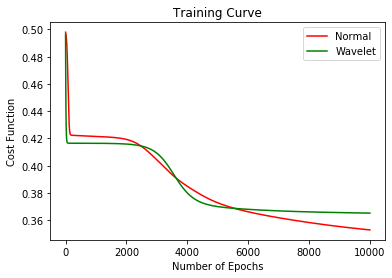

In [93]:
layers_sizes = [8, 17, 6]
epochs = 10000
lr = 0.03
TAKE_BIAS = False
error_function = "mean_square"
activations_normal = ["tanh","linear"]
activations_wavelet = ["gaussian_wavelet","linear"]
weight_types_NN = ["Normal","Normal"]
weight_types_WNN = ["Wavelet","Normal"]
print("******************** NORMAL ARTIFICIAL NEURAL NETWORK ********************")
weights_normal = H_layer_NN(X_train, Y_train, layers_sizes, activations_normal, epochs, lr, TAKE_BIAS,weight_types_NN)
print("******************** NORMAL ARTIFICIAL NEURAL NETWORK PREDICTION********************")
training_predictions_normal = predict(X_train, Y_train, weights_normal, activations_normal, "Train",False,weight_types_NN)
# test_predictions_normal = predict(X_test, Y_test, weights_normal, activations_normal, "Test",False,weight_types_NN)
print("******************** WAVELET NEURAL NETWORK ********************")

weights_wavelet = H_layer_NN(X_train, Y_train, layers_sizes, activations_wavelet, epochs, lr, TAKE_BIAS,weight_types_WNN)
print("******************** WAVELET NEURAL PREDICTION ********************")
training_predictions_wavelet = predict(X_train, Y_train, weights_wavelet, activations_wavelet, "Train",TAKE_BIAS,weight_types_WNN)
# test_predictions_wavelet = predict(X_test, Y_test, weights_wavelet, activations_wavelet, "Test",TAKE_BIAS,weight_types_WNN)
plt.legend(["Normal","Wavelet"])

### Results

In [94]:
training_predictions_normal = predict(X_train, Y_train, weights_normal, activations_normal, "Train",False,weight_types_NN)
test_predictions_normal = predict(X_test, Y_test, weights_normal, activations_normal, "Test",False,weight_types_NN)
training_predictions_wavelet = predict(X_train, Y_train, weights_wavelet, activations_wavelet, "Train",TAKE_BIAS,weight_types_WNN)
test_predictions_wavelet = predict(X_test, Y_test, weights_wavelet, activations_wavelet, "Test",TAKE_BIAS,weight_types_WNN)

Normal Neural Network: Train Cost: 0.35290148548613764
Normal Neural Network: Train Accuracy: 0.3761904761904762
Normal Neural Network: Test Cost: 0.34232011557450465
Normal Neural Network: Test Accuracy: 0.4
Wavelet Neural Network: Train Cost: 0.36523373499278794
Wavelet Neural Network: Train Accuracy: 0.2968253968253968
Wavelet Neural Network: Test Cost: 0.36072699983217527
Wavelet Neural Network: Test Accuracy: 0.35185185185185186


# TO DO: 
* Wavelet Functions
* Fix Prediction Functions
* Set Model Architecture
* Train and Compare